In [3]:
%matplotlib inline

In [4]:
!pip install -U tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 5.3 MB/s 
     |████████████████████████████████| 154 kB 53.7 MB/s 



# Non-negative Tucker decomposition in Tensorly >=0.6
Example and comparison of Non-negative Tucker decompositions.


## Introduction
Since version 0.6 in Tensorly, two algorithms are available to compute non-negative
Tucker decomposition:

1. Multiplicative updates (MU) (already in Tensorly < 0.6)
2. Non-negative Alternating Least Squares (ALS) using Hierarchical ALS (HALS)

Non-negativity is an important constraint to handle for tensor decompositions.
One could expect that core and factors must have only non-negative values after
it is obtained from a non-negative tensor. Tucker decomposition includes core
($G$) and factors ($A$, $B$, $C$).

\begin{align}T = [| G; A, B , C |],\end{align}

We need to solve the following problem for each factor (e.g. factor $A$ here):

\begin{align}\min_{A \geq 0} ||T_{[1]} - A\times G_{[1]}(B\times C)^T||_F^2,\end{align}

Here, $G_{[i]}$ represents ith mode unfolding of the core. To update
the core, we need the solve following problem:

\begin{align}\min_{g \geq 0} ||t -   (A\times B \times C)\times g ||_F^2,\end{align}

where $t$ and $g$ are the vectorized data tensor $T$ and core $G$.



To update the factors, we will use HALS and to update the core, we have two
different algorithms Active Set (AS) and Fast Iterative Shrinkage-Thresholding
Algorithm (FISTA) in Tensorly. While FISTA is an accelerated gradient method for
non-negative or unconstrained problems, AS is the widely used non-negative
least square solution proposed by Lawson and Hanson in 1974. Both algorithms
return non-negative core and FISTA is the default algorithm for HALS Tucker
decomposition in Tensorly.



In [5]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker, non_negative_tucker_hals
import time
from tensorly.metrics.regression import RMSE
import matplotlib.pyplot as plt

## Create synthetic tensor
There are several ways to create a tensor with non-negative entries in Tensorly.
Here we chose to generate a random tensor from the sequence of integers from
1 to 1000.



In [6]:
# tensor generation
array = np.random.randint(1000, size=(10, 30, 40))
tensor = tl.tensor(array, dtype='float')

## Non-negative Tucker
First, multiplicative update can be implemented as:



In [7]:
tic = time.time()
tensor_mu, error_mu = non_negative_tucker(tensor, rank=[5, 5, 5], tol=1e-12, n_iter_max=100, return_errors=True)
tucker_reconstruction_mu = tl.tucker_to_tensor(tensor_mu)
time_mu = time.time()-tic

Here, we also compute the output tensor from the decomposed factors by using
the ``tucker_to_tensor`` function. The tensor ``tucker_reconstruction_mu`` is
therefore a low-rank non-negative approximation of the input tensor ``tensor``.



## Non-negative Tucker with HALS and FISTA
HALS algorithm with FISTA can be calculated as:



In [8]:
ticnew = time.time()
tensor_hals_fista, error_fista = non_negative_tucker_hals(tensor, rank=[5, 5, 5], algorithm='fista', return_errors=True)
tucker_reconstruction_fista = tl.tucker_to_tensor(tensor_hals_fista)
time_fista = time.time()-ticnew

## Non-negative Tucker with HALS and Active Set
As a second option, HALS algorithm with Active Set can be called as follows:



In [9]:
ticnew = time.time()
tensor_hals_as, error_as = non_negative_tucker_hals(tensor, rank=[5, 5, 5], algorithm='active_set', return_errors=True)
tucker_reconstruction_as = tl.tucker_to_tensor(tensor_hals_as)
time_as = time.time()-ticnew

## Comparison
To compare the various methods, first we may look at each algorithm
processing time:



In [10]:
print('time for tensorly nntucker:'+' ' + str("{:.2f}".format(time_mu)))
print('time for HALS with fista:'+' ' + str("{:.2f}".format(time_fista)))
print('time for HALS with as:'+' ' + str("{:.2f}".format(time_as)))

time for tensorly nntucker: 0.18
time for HALS with fista: 2.89
time for HALS with as: 2.40


All algorithms should run with about the same number of iterations on our
example, so at first glance the MU algorithm is faster (i.e. has lower
per-iteration complexity). A second way to compare methods is to compute
the error between the output and input tensor. In Tensorly, there is a function
to compute Root Mean Square Error (RMSE):



In [11]:
print('RMSE tensorly nntucker:'+' ' + str(RMSE(tensor, tucker_reconstruction_mu)))
print('RMSE for hals with fista:'+' ' + str(RMSE(tensor, tucker_reconstruction_fista)))
print('RMSE for hals with as:'+' ' + str(RMSE(tensor, tucker_reconstruction_as)))

RMSE tensorly nntucker: 287.5828708523335
RMSE for hals with fista: 281.03296377124803
RMSE for hals with as: 281.0347485933437


According to the RMSE results, HALS is better than the multiplicative update
with both FISTA and active set core update options. We can better appreciate
the difference in convergence speed on the following error per iteration plot:



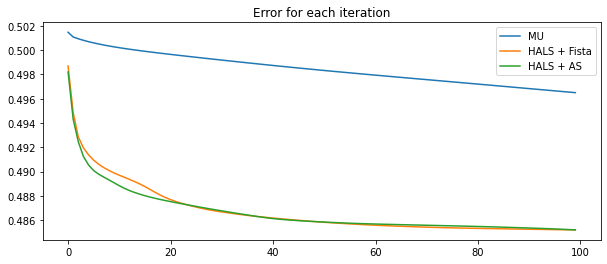

In [12]:
def each_iteration(a,b,c,title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.title(str(title))
    plt.legend(['MU', 'HALS + Fista', 'HALS + AS'], loc='upper right')


each_iteration(error_mu, error_fista, error_as, 'Error for each iteration')

In conclusion, on this quick test, it appears that the HALS algorithm gives
much better results than the MU original Tensorly methods. Our recommendation
is to use HALS as a default, and only resort to MU in specific cases
(only encountered by expert users most likely). Besides, in this experiment
FISTA and active set give very similar results, however active set may last
longer when it is used with higher ranks according to our experience.
Therefore, we recommend to use FISTA with high rank decomposition.



## References

Gillis, N., & Glineur, F. (2012). Accelerated multiplicative updates and
hierarchical ALS algorithms for nonnegative matrix factorization.
Neural computation, 24(4), 1085-1105. (Link)
<https://direct.mit.edu/neco/article/24/4/1085/7755/Accelerated-Multiplicative-Updates-and>
